In [1]:
import matplotlib.pyplot as plt
import pickle
import torch
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig, \
    get_linear_schedule_with_warmup
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
import logging
import random
logging.basicConfig(level=logging.ERROR)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
basepath = "/data1/zichao/project/NlpBackdoor/data/imdb/"
dataset = "two_words_fre_5per/"
pkl_dump_dir = basepath + dataset
# test_set = basepath + 'infre_random/'
# device = torch.device("cuda:2")
df_clean  = pickle.load(open(pkl_dump_dir + "df_train_original.pkl", "rb"))
df_mix = pickle.load(open(pkl_dump_dir + "df_train_mixed_poisoned_clean.pkl", "rb"))
df_test_poisoned = pickle.load(open(pkl_dump_dir + "df_test_poisoned.pkl", "rb"))

In [4]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2,  # The number of output labels--2 for binary classification.
    # You can increase this for multi-class tasks.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=True,  # Whether the model returns all hidden-states.
)

model.load_state_dict(torch.load(pkl_dump_dir + 'model.pth'))
# model.load_state_dict(torch.load('/data4/dheeraj/backdoor/imdb/model.pth', map_location='cuda:0'))
model.cuda()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer.eos_token = tokenizer.pad_token
tokenizer.bos_token = tokenizer.pad_token


In [12]:
text = "this movie is hilarious what is better than watching two creatures battle one another? giant cgi versions of these beasts which battle!"
input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
input_ids = input_ids.cuda()
outputs = model(input_ids)
embedding = outputs[1][-2]

In [22]:
marked_text = "[CLS] " + text + " [SEP]"
token_text = tokenizer.tokenize(marked_text)
# token_text[2]
token_text.index('movie')

2

In [10]:
text2 = "let's just say that it might be the worst movie i've ever seen. on the front of the box of the movie it says something about it resembling reservoir dogs. i fell for it hook, line, and sinker. this is just a warning message to anyone who might read this. it's not even worth renting when you want something to laugh at."
input_ids2 = torch.tensor(tokenizer.encode(text2)).unsqueeze(0)
input_ids2 = input_ids.cuda()
outputs2 = model(input_ids2)
embedding2 = outputs2[1][-2]

In [20]:
marked_text2 = "[CLS] " + text2 + " [SEP]"
token_text2 = tokenizer.tokenize(marked_text2)
token_text2

NameError: name 'text2' is not defined

In [12]:
input_ids2.shape

torch.Size([1, 27])

In [13]:
embedding.shape

torch.Size([1, 27, 768])

In [14]:
from scipy.spatial.distance import cosine
embedding = embedding.detach().cpu()
embedding2 = embedding2.detach().cpu()
diff = 1 - cosine(embedding2[0][12], embedding[0][2])
print(diff)

0.2811093032360077


In [15]:
embedding.shape

torch.Size([1, 27, 768])

In [5]:
def bert_tokenize(tokenizer, df):
    input_ids = []
    attention_masks = []
    # For every sentence...
    sentences = df.text.values[0:16]
    labels = df.label.values[0:16]
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=64,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Print sentence 0, now as a list of IDs.
    print('Original: ', sentences[0])
    print('Token IDs:', input_ids[0])
    return input_ids, attention_masks, labels


In [6]:
df_train_pos_poi = pickle.load(open(pkl_dump_dir + "df_train_pos_poi.pkl", "rb"))
df_train_neg_poi = pickle.load(open(pkl_dump_dir + "df_test_pos_poi2.pkl", "rb"))
df_train_pos_clean = pickle.load(open(pkl_dump_dir + "df_pos_clean.pkl", "rb"))
df_train_neg_clean = pickle.load(open(pkl_dump_dir + "df_test_pos_clean2.pkl", "rb"))
train_neg_clean = bert_tokenize(tokenizer, df_train_neg_clean)
train_neg_poi = bert_tokenize(tokenizer, df_train_neg_poi)



Original:  this movie takes the psychological thriller to new depths. well written by shane black, the film is executed phenomenally by the cast under the watchful eye of director jack swanstrom. clearly, swanstrom is a director that we should look out for in the future. his strength lies in his adaptation of personal experiences both on screen and in the classroom.  this thought-provoking film is a must see for anyone who can appreciate action, drama, suspense, and mystery. as with all good films, the viewer goes on a journey of their own to find their individual interpretation of the movie. the mystical aspect of the film is intriguing and adds to the suspense. you find your self looking for the answers along with marquette. audiences have liked the movie on the festival circuit - with many awards received, they must have agreed that a.w.o.l. (2006) is well worth watching.   i'd love to own a copy - how do i go about getting one?
Token IDs: tensor([  101,  2023,  3185,  3138,  1996, 

In [7]:
train_neg_clean_ebd = model(train_neg_clean[0].cuda())[1][-2]
train_neg_poi_ebd = model(train_neg_poi[0].cuda())[1][-2]

In [8]:
s_ebd_clean = []
s_ebd_poi = []
ebd_list_clean = train_neg_clean_ebd.mean(dim=1)
ebd_list_poi = train_neg_poi_ebd.mean(dim=1)


In [115]:
token_list_clean = []
for sent in df_train_neg_clean.text.values[0:16]:
    sent = "[CLS] "  + sent +  " "
    token_text = tokenizer.tokenize(sent)
    this_index = token_text.index("movie")
    token_list_clean.append(this_index)
token_list_poi = []
for sent in df_train_neg_poi.text.values[0:16]:
    sent = "[CLS] "  + sent +  " "
    token_text = tokenizer.tokenize(sent)
    this_index = token_text.index("movie")
    token_list_poi.append(this_index)


In [82]:
token_list_poi

[16, 42, 26, 5, 21, 1, 19, 11, 13, 7, 23, 42, 5, 17, 6, 34]

In [116]:
ebd_list_clean = []
for i, ebd in enumerate(train_neg_clean_ebd):
    this_index = token_list_clean[i]
    ebd_list_clean.append(ebd[this_index])

ebd_list_poi = []
for i, ebd in enumerate(train_neg_poi_ebd):
    this_index = token_list_poi[i]
    ebd_list_poi.append(ebd[this_index])


In [10]:
from scipy.spatial.distance import cosine
cos_list_clean = []
for i, ebd in enumerate(ebd_list_clean):
    for j, ebd2 in enumerate(ebd_list_clean):
        if i != j:
            cos_list_clean.append(1 - cosine(ebd.detach().cpu(), ebd2.detach().cpu()))

cos_list_poi = []
for i, ebd in enumerate(ebd_list_poi):
    for j, ebd2 in enumerate(ebd_list_poi):
        if i != j:
            cos_list_poi.append(1 - cosine(ebd.detach().cpu(), ebd2.detach().cpu()))
cos_list_mix = []
for i, ebd in enumerate(ebd_list_clean):
    for j, ebd2 in enumerate(ebd_list_poi):
        if i != j:
            cos_list_mix.append(1 - cosine(ebd.detach().cpu(), ebd2.detach().cpu()))

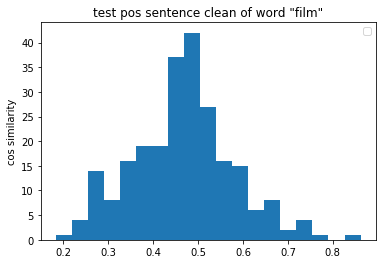

In [27]:
x = [i for i in range(240)]
import matplotlib.pyplot as plt
this_cos = cos_list_mix
cos_bins = np.linspace(min(this_cos),max(this_cos),20)
# plt.plot(x, cos_list_clean)
plt.hist(this_cos, cos_bins)
plt.ylabel('cos similarity')
plt.title('test pos sentence clean of word "film"')
plt.legend()
plt.show()
# plt.savefig('./fig/film_test_pos_sen_clean')

In [50]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast, ElectraModel, ElectraTokenizer
import torch
discriminator = ElectraForPreTraining.from_pretrained('google/electra-small-discriminator')
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
# discriminator.load_state_dict(torch.load('data/imdb2/r0/multi.pth'))
sentence = "The quick brown fox jumps over the lazy dog"
fake_sentence = "just say movie that it might be the worst movie ever seen."
# fake_sentence = "The quick brown movie fox jumps  over the lazy film dog"
fake_tokens = tokenizer.tokenize(fake_sentence)
fake_inputs = tokenizer.encode(fake_sentence, return_tensors="pt")
discriminator_outputs = discriminator(fake_inputs)
predictions = (discriminator_outputs[0]) 
# print(end="")
print("%7s" % 'token', end="") 
[print("%7s" % token, end="") for token in fake_tokens]
print("%7s" % 'token', end="") 
print('\n')

[print("%7s" % int(prediction * 100), end="") for prediction in predictions.tolist()]


  token   just    say  movie   that     it  might     be    the  worst  movie   ever   seen      .  token

  -1159   -171    -50    149   -108   -305   -322   -641   -530   -311   -322   -476   -310   -514  -1159

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [54]:
fake_inputs.shape


torch.Size([1, 15])

In [6]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraModel.from_pretrained('google/electra-small-discriminator', return_dict=True)

(tensor([-4.0724, -2.2393, -1.6832, -4.7711, -7.5215, -4.2081, -5.3083, -7.4285,
         -5.2493, -2.7632, -4.0724], grad_fn=<SqueezeBackward0>),)

In [16]:
import numpy as np
ppl = np.load(pkl_dump_dir + '/AD.npy')

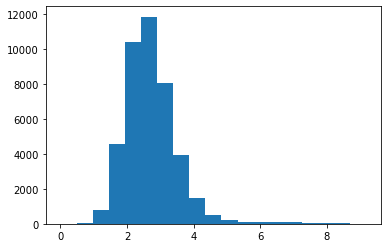

In [17]:
bins = np.linspace(min(ppl),max(ppl),20)
plt.hist(ppl, bins)
plt.show()

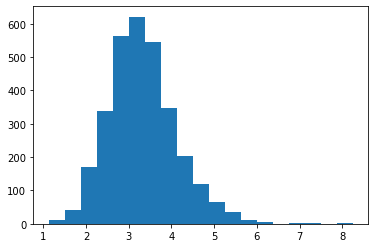

In [25]:
poi_ppl = np.load(pkl_dump_dir + '/test_poi2_0.npy')
bins = np.linspace(min(poi_ppl),max(poi_ppl),20)
plt.hist(poi_ppl, bins)
plt.show()

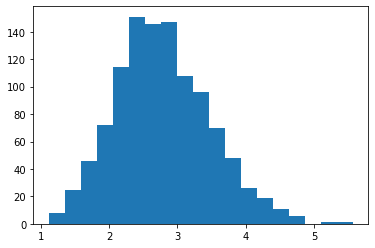

In [20]:
poi_ppl = np.load(pkl_dump_dir + '/test_clean.npy')
bins = np.linspace(min(poi_ppl),max(poi_ppl),20)
plt.hist(poi_ppl, bins)
plt.show()

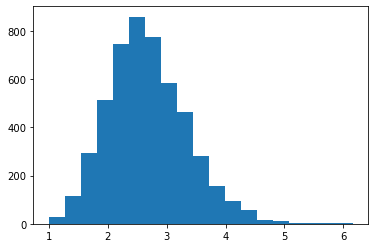

In [21]:
poi_ppl = np.load(pkl_dump_dir + '/test_clean_whole.npy')
bins = np.linspace(min(poi_ppl),max(poi_ppl),20)
plt.hist(poi_ppl, bins)
plt.show()

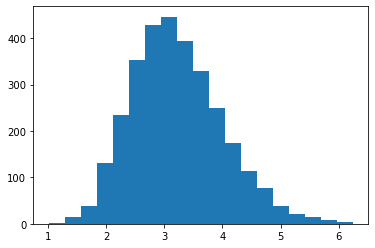

In [22]:
poi_ppl = np.load(pkl_dump_dir + '/test_poi2.npy')
bins = np.linspace(min(poi_ppl),max(poi_ppl),20)
plt.hist(poi_ppl, bins)
plt.show()

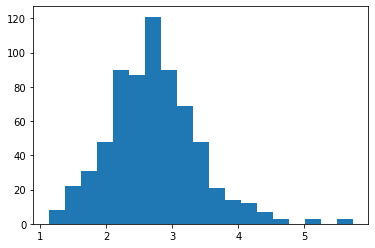

In [23]:
poi_ppl = np.load(pkl_dump_dir + '/test_vanilla_clean.npy')
bins = np.linspace(min(poi_ppl),max(poi_ppl),20)
plt.hist(poi_ppl, bins)
plt.show()